In [1]:
from enum import Enum
from itertools import product
from random import choice, randint, random, seed

import numpy as np

In [151]:
import pandas as pd

from seaborn import heatmap

# def draw_cells(cells, start, end, history, ax=None):
def draw_cells(cells, history, ax=None):
    start = history[0]
    end = history[-1]
    df = pd.DataFrame(cells, columns=['x', 'y'])
    size = df.max() - df.min()
    df['z'] = 0
    df = df.set_index(['x', 'y']).z.unstack().fillna(-1).astype(int)
    for h in history:
        df.loc[tuple(h)] = 3
    df.loc[end] = 2
    df.loc[start] = 1
    ax = heatmap(
        df.T.sort_index(ascending=False),
        linewidths=1,
        cbar=False,
        square=True,
        cmap=['black', 'tab:grey', 'tab:red', 'tab:green', 'tab:blue'],
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xticks([])
    # ax.set_yticks([])

    return df

In [152]:
class Direction(Enum):
    EAST = (1, 0)
    NORTH = (0, 1)
    WEST = (-1, 0)
    SOUTH = (0, -1)

    def succ(self):
        x = -self.value[1]
        y = self.value[0]
        return Direction(x, y)

    def pred(self):
        x = self.value[1]
        y = -self.value[0]
        return Direction(x, y)

In [273]:
class DungeonGenerator:
    def __init__(self, hallway_length, room_size):
        hallway = np.arange(hallway_length) + 1
        self.hallway = np.vstack([hallway, hallway]).T
        self.room_size = room_size
        self.room = np.array(list(product(range(room_size), range(room_size))))

    def new_door(self, position, direction):
        position = np.array(position)
        direction = np.array(direction.value)
        door_position = position + direction
        print(f'new door at {door_position}')
        return door_position

    def new_hallway(self, position, direction):
        position = np.array(position)
        direction = np.array(direction.value)
        hallway_positions = position + self.hallway * direction
        print(f'new hallway from {hallway_positions[0]} to {hallway_positions[-1]}')
        return hallway_positions

    def new_room(self, position, direction):
        position = np.array(position)
        room_direction = np.array(direction.succ().value)
        player_direction = np.array(direction.value)

        room_positions = position + player_direction + self.room - abs(room_direction * (self.room_size // 2)) + self.room_size * player_direction
        print(f'new {self.room_size}x{self.room_size} room from {room_positions[0]} to {room_positions[-1]}')
        return room_positions

In [271]:
dungen = DungeonGenerator(5, 5)

new hallway from [ 0 -1] to [ 0 -5]
new door at [ 1 -5]
new 5 x 5 room from [ 7 -7] to [11 -3]


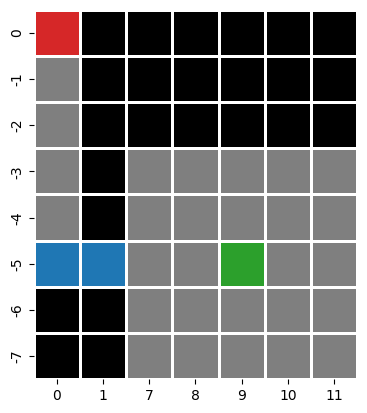

In [272]:
start = (0, 0)
history = [start]
cells = {start}
direction = Direction.SOUTH

hallway = dungen.new_hallway(history[-1], direction)
for p in hallway:
    cells.add((int(p[0]), int(p[1])))
history.append((int(hallway[-1][0]), int(hallway[-1][1])))

direction = Direction.EAST

door = dungen.new_door(history[-1], direction)
cells.add((int(door[0]), int(door[1])))
history.append((int(door[0]), int(door[1])))

room = dungen.new_room(history[-1], direction)
for p in room:
    cells.add((int(p[0]), int(p[1])))
history.append(tuple(room[len(room) // 2]))

dungeon_map = draw_cells(cells, history)

In [ ]:
def step(position, direction):
    roll = randint(1, 20)
    cells = set()
    if 1 <= roll <= 2:
        print('creating a double hallway')
        hallway = dungen.new_hallway(history[-1], direction)
        for p in hallway:
            cells.add((int(p[0]), int(p[1])))
        history.append(tuple(hallway[-1]))
        hallway = dungen.new_hallway(history[-1], direction)
        for p in hallway:
            cells.add((int(p[0]), int(p[1])))
        history.append(tuple(hallway[-1]))
    elif 3 <= roll <= 5:
        roll = randint(1, 20)
        if 1 <= roll <= 6:
            new_direction = 'east'
        elif 7 <= roll <= 12:
            new_direction = 'west'
        else:
            # create a room if we are just stepping forward
            print('creating a door')
            door = self.door * self.direction
            new_cells = self.door * self.direction
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = new_cells[-1]

            print('creating a room')
            room_size = choice(list(self.room_shapes.keys()))
            room = self.room_shapes[room_size]
            center = self.position + room_size * self.direction
            new_cells = center + room
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = center
            return

        # otherwise turn and step through a door
        print('creating a door')
        self.direction = CARDINALS[new_direction]
        new_cells = self.position + self.door * self.direction
        self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
        self.position = new_cells[-1]
    elif 6 <= roll <= 10:
        print('creating a hallway')
        # create a hallway
        new_cells = self.position + self.hallway * self.direction
        self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
        self.position = new_cells[-1]
    elif 11 <= roll <= 13:
        # create a hallway
        print('creating a turn')
        self.direction = choice([c for c in CARDINALS.values() if not np.array_equal(c, self.direction) and not np.array_equal(c, -self.direction)])
        print('creating a hallway')
        new_cells = self.position + self.hallway * self.direction
        self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
        self.position = new_cells[-1]
    elif 14 <= roll <= 16:
        print('creating a room')
        room_size = choice(list(self.room_shapes.keys()))
        room = self.room_shapes[room_size]
        center = self.position + room_size * self.direction
        new_cells = center + room
        self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
        self.position = center
    elif roll == 17:
        pass
    elif roll == 18:
        pass
    elif roll == 19:
        pass
    else:
        pass
    # if steps > 2 and random() > 0.50:
    #     # create a room
    #     room_size = choice(ROOM_SIZES)
    #     room = ROOMS[room_size]
    #     center = current + room_size * direction
    #     new_cells = center + room
    #     cells = cells | {tuple(map(int, c)) for c in new_cells}
    #     direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])
    #     current = center + room_size * direction
    #     steps = 0
    # else:
    #     # create a hallway
    #     new_cells = current + HALLWAY * direction
    #     cells = cells | {tuple(map(int, c)) for c in new_cells}
    #     current = new_cells[-1]
    #     steps += 1
    #     if random() > 0.75:
    #         direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])

In [ ]:
CARDINALS = {
    'east': np.array((1, 0)),
    'north': np.array((0, 1)),
    'west': np.array((-1, 0)),
    'south': np.array((0, -1)),
}

In [ ]:
class DungeonGenerator:
    def __init__(self, door, hallway, rooms):
        steps = np.arange(door) + 1
        self.door = np.vstack([steps, steps]).T

        steps = np.arange(hallway) + 1
        self.hallway = np.vstack([steps, steps]).T

        self.room_shapes = {}
        for room_size in rooms:
            steps = np.mgrid[-room_size:(room_size + 1):1, -room_size:(room_size + 1):1].T.reshape(-1, 2)
            self.room_shapes[room_size] = steps

        self.cells = {}
        # self.doors = []
        # self.hallways = []
        # self.rooms = []

    def start(self, start, direction):
        self.position = np.array(start)
        self.direction = direction
        self.cells = {tuple(start)}

    def step(self):
        roll = randint(1, 20)
        if 1 <= roll <= 2:
            print('creating a double hallway')
            # create a hallway
            new_cells = self.position + 2 * self.hallway * self.direction
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = new_cells[-1]
        elif 3 <= roll <= 5:
            roll = randint(1, 20)
            if 1 <= roll <= 6:
                new_direction = 'east'
            elif 7 <= roll <= 12:
                new_direction = 'west'
            else:
                # create a room if we are just stepping forward
                print('creating a door')
                door = self.door * self.direction
                new_cells = self.door * self.direction
                self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
                self.position = new_cells[-1]

                print('creating a room')
                room_size = choice(list(self.room_shapes.keys()))
                room = self.room_shapes[room_size]
                center = self.position + room_size * self.direction
                new_cells = center + room
                self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
                self.position = center
                return

            # otherwise turn and step through a door
            print('creating a door')
            self.direction = CARDINALS[new_direction]
            new_cells = self.position + self.door * self.direction
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = new_cells[-1]
        elif 6 <= roll <= 10:
            print('creating a hallway')
            # create a hallway
            new_cells = self.position + self.hallway * self.direction
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = new_cells[-1]
        elif 11 <= roll <= 13:
            # create a hallway
            print('creating a turn')
            self.direction = choice([c for c in CARDINALS.values() if not np.array_equal(c, self.direction) and not np.array_equal(c, -self.direction)])
            print('creating a hallway')
            new_cells = self.position + self.hallway * self.direction
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = new_cells[-1]
        elif 14 <= roll <= 16:
            print('creating a room')
            room_size = choice(list(self.room_shapes.keys()))
            room = self.room_shapes[room_size]
            center = self.position + room_size * self.direction
            new_cells = center + room
            self.cells = self.cells | {tuple(map(int, c)) for c in new_cells}
            self.position = center
        elif roll == 17:
            pass
        elif roll == 18:
            pass
        elif roll == 19:
            pass
        else:
            pass
        # if steps > 2 and random() > 0.50:
        #     # create a room
        #     room_size = choice(ROOM_SIZES)
        #     room = ROOMS[room_size]
        #     center = current + room_size * direction
        #     new_cells = center + room
        #     cells = cells | {tuple(map(int, c)) for c in new_cells}
        #     direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])
        #     current = center + room_size * direction
        #     steps = 0
        # else:
        #     # create a hallway
        #     new_cells = current + HALLWAY * direction
        #     cells = cells | {tuple(map(int, c)) for c in new_cells}
        #     current = new_cells[-1]
        #     steps += 1
        #     if random() > 0.75:
        #         direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])

In [ ]:
seed(1)
generator = DungeonGenerator(1, 6, [2, 3, 4, 5])
generator.start((0, 0), CARDINALS['north'])
history = []

In [ ]:
generator.step()
history.append(tuple(generator.position))
draw_cells(generator.cells, (0, 0), tuple(generator.position), history)

In [ ]:
HALLWAY_LENGTH = 6
HALLWAY = np.vstack([np.arange(1, HALLWAY_LENGTH + 2), np.arange(1, HALLWAY_LENGTH + 2)]).reshape(-1, HALLWAY_LENGTH + 1).T
ROOM_SIZES = [2, 3, 4, 5]
ROOMS = {size: np.mgrid[-size:(size + 1):1, -size:(size + 1):1].reshape(2, -1).T for size in ROOM_SIZES}

def generate_dungeon(max_cells, start):
    current = np.array(start)
    cells = {tuple(start)}
    history = []
    direction = choice(CARDINALS)
    steps = 0
    for _ in range(max_cells):
    # while len(cells) < max_cells:
        if steps > 2 and random() > 0.50:
            # create a room
            room_size = choice(ROOM_SIZES)
            room = ROOMS[room_size]
            center = current + room_size * direction
            new_cells = center + room
            cells = cells | {tuple(map(int, c)) for c in new_cells}
            direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])
            current = center + room_size * direction
            steps = 0
        else:
            # create a hallway
            new_cells = current + HALLWAY * direction
            cells = cells | {tuple(map(int, c)) for c in new_cells}
            current = new_cells[-1]
            steps += 1
            if random() > 0.75:
                direction = choice([c for c in CARDINALS if not np.array_equal(c, -direction)])
        history.append(current)
    return cells, tuple(current), history[:-1]

In [ ]:
seed(1)

start = (0, 0)
start_direction = (0, 1)
cells, end, history = generate_dungeon(13, start)
draw_cells(cells, start, end, history)